# Adapting High-resource NMT Models to Translate Low-resource Related Languages while Keeping into Account Catastrophic Forgetting

Done by: Jardenna Mohazzab, Mehdi Oueslati, Venkat Mohit Sornapudi, Lea Tiyavorabun

Few components in this assignment have been imported from https://www.tensorflow.org/text/tutorials/transformer tutorial.

## Setup

In [ ]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be DOWNGRADED:
  libcudnn8
0 upgraded, 0 newly installed, 1 downgraded, 1 to remove and 10 not upgraded.
Need to get 430 MB of archives.
After this operation, 1,392 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 7s (59.6 MB/s)
(Reading database ... 123934 files and directories currently installed.)
Removing libcudnn8-dev (8.1.1.33-1+cuda11.2) ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
dpkg: warning: downgrading libcudnn8 from 8.1.1.33-1+cuda11.2 to

In [ ]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

## Data handling

### Download the dataset

Loading the [Portuguese-English translation dataset](https://www.tensorflow.org/datasets/catalog/ted_hrlr_translate#ted_hrlr_translatept_to_en)from TED Talks Open Translation Project. This dataset contains approximately 52,000 training, 1,200 validation and 1,800 test examples.

In [ ]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en',
                               with_info=True,
                               as_supervised=True)

train_examples, val_examples = examples['train'], examples['validation']

In [ ]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
  print('> Examples in Portuguese:')
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))
  print()

  print('> Examples in English:')
  for en in en_examples.numpy():
    print(en.decode('utf-8'))

> Examples in Portuguese:
e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

> Examples in English:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


In [ ]:
len(examples['train'])

51785

### Set up the tokenizer

In [ ]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

'./ted_hrlr_translate_pt_en_converter.zip'

In [ ]:
tokenizers = tf.saved_model.load(model_name)

In [ ]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

The `tokenize` method converts a batch of strings to a padded-batch of token IDs. This method splits punctuation, lowercases and unicode-normalizes the input before tokenizing.

In [ ]:
print('> This is a batch of strings:')
for en in en_examples.numpy():
  print(en.decode('utf-8'))

> This is a batch of strings:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


In [ ]:
encoded = tokenizers.en.tokenize(en_examples)

print('> This is a padded-batch of token IDs:')
for row in encoded.to_list():
  print(row)

> This is a padded-batch of token IDs:
[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


The `detokenize` method attempts to convert these token IDs back to human-readable text:

In [ ]:
round_trip = tokenizers.en.detokenize(encoded)

print('> This is human-readable text:')
for line in round_trip.numpy():
  print(line.decode('utf-8'))

> This is human-readable text:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


In [ ]:
print('> This is the text split into tokens:')
tokens = tokenizers.en.lookup(encoded)
tokens

> This is the text split into tokens:


<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ,
 [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for',
  b'curiosity', b'.', b'[END]']                                          ]>

In [ ]:
lengths = []

for pt_examples, en_examples in train_examples.batch(1024):
  pt_tokens = tokenizers.pt.tokenize(pt_examples)
  lengths.append(pt_tokens.row_lengths())

  en_tokens = tokenizers.en.tokenize(en_examples)
  lengths.append(en_tokens.row_lengths())
  print('.', end='', flush=True)

...................................................

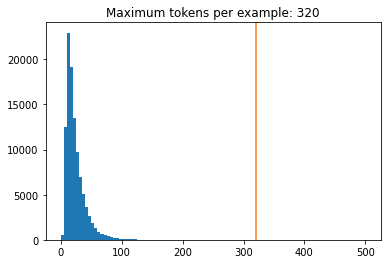

In [ ]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');

### Set up a data pipeline with `tf.data`

In [ ]:
MAX_TOKENS=128
def prepare_batch(pt, en):
    pt = tokenizers.pt.tokenize(pt)      # Output is ragged.
    pt = pt[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    pt = pt.to_tensor()  # Convert to 0-padded dense Tensor

    en = tokenizers.en.tokenize(en)
    en = en[:, :(MAX_TOKENS+1)]
    en_inputs = en[:, :-1].to_tensor()  # Drop the [END] tokens
    en_labels = en[:, 1:].to_tensor()   # Drop the [START] tokens

    return (pt, en_inputs), en_labels

In [ ]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [ ]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

 </section>

## Test the Dataset

In [ ]:
# Create training and validation set batches.
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

In [ ]:
for (pt, en), en_labels in train_batches.take(1):
  break

print(pt.shape)
print(en.shape)
print(en_labels.shape)

(64, 65)
(64, 83)
(64, 83)


The `en` and `en_labels` are the same, just shifted by 1:

In [ ]:
print(en[0][:10])
print(en_labels[0][:10])

tf.Tensor([  2  76  80 715  75  71 143 208  80 170], shape=(10,), dtype=int64)
tf.Tensor([ 76  80 715  75  71 143 208  80 170 121], shape=(10,), dtype=int64)


## Defining the components

<table>
<tr>
  <th colspan=1>The original Transformer diagram</th>
  <th colspan=1>A representation of a 4-layer Transformer</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png"/>
  </td>
  <td>
   <img width=307 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-4layer-compact.png"/>
  </td>
</tr>
</table>

### The embedding and positional encoding layer

The inputs to both the encoder and decoder use the same embedding and positional encoding logic.

<table>
<tr>
  <th colspan=1>The embedding and positional encoding layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/PositionalEmbedding.png"/>
  </td>
</tr>
</table>

The formula for calculating the positional encoding (implemented in Python below) is as follows:

$$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

In [ ]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

(2048, 512)


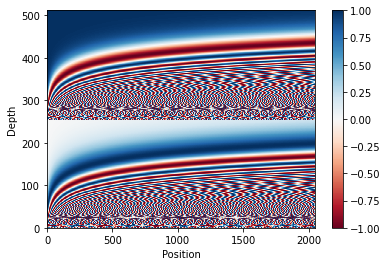

In [ ]:
#@title
pos_encoding = positional_encoding(length=2048, depth=512)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

(0.0, 1.0)

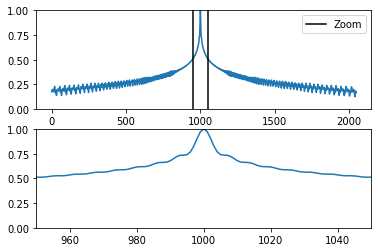

In [ ]:
#@title
pos_encoding/=tf.norm(pos_encoding, axis=1, keepdims=True)
p = pos_encoding[1000]
dots = tf.einsum('pd,d -> p', pos_encoding, p)
plt.subplot(2,1,1)
plt.plot(dots)
plt.ylim([0,1])
plt.plot([950, 950, float('nan'), 1050, 1050],
         [0,1,float('nan'),0,1], color='k', label='Zoom')
plt.legend()
plt.subplot(2,1,2)
plt.plot(dots)
plt.xlim([950, 1050])
plt.ylim([0,1])


In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x


In [ ]:
embed_pt = PositionalEmbedding(vocab_size=tokenizers.pt.get_vocab_size(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=tokenizers.en.get_vocab_size(), d_model=512)

pt_emb = embed_pt(pt)
en_emb = embed_en(en)

In [ ]:
en_emb._keras_mask

### Adding and normalizing

<table>
<tr>
  <th colspan=2>Add and normalize</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Add+Norm.png"/>
  </td>
</tr>
</table>

### The base attention layer

Attention layers are used throughout the model. These are all identical except for how the attention is configured. Each one contains a `layers.MultiHeadAttention`, a `layers.LayerNormalization` and a `layers.Add`.

<table>
<tr>
  <th colspan=2>The base attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/BaseAttention.png"/>
  </td>
</tr>
</table>

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

### The cross attention layer


<table>
<tr>
  <th colspan=1>The cross attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention.png"/>
  </td>
</tr>
</table>

In [ ]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [ ]:
sample_ca = CrossAttention(num_heads=2, key_dim=512)

print(pt_emb.shape)
print(en_emb.shape)
print(sample_ca(en_emb, pt_emb).shape)

(64, 65, 512)
(64, 83, 512)
(64, 83, 512)


### The global self attention layer

<table>
<tr>
  <th colspan=1>The global self attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention.png"/>
  </td>
</tr>
</table>

In [ ]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [ ]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print(pt_emb.shape)
print(sample_gsa(pt_emb).shape)

(64, 65, 512)
(64, 65, 512)


### The causal self attention layer

<table>
<tr>
  <th colspan=1>The causal self attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention.png"/>
  </td>
</tr>
</table>

In [ ]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [ ]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

print(en_emb.shape)
print(sample_csa(en_emb).shape)

(64, 83, 512)
(64, 83, 512)


In [ ]:
out1 = sample_csa(embed_en(en[:, :3]))
out2 = sample_csa(embed_en(en))[:, :3]

tf.reduce_max(abs(out1 - out2)).numpy()

5.9604645e-07

### The feed forward network

<table>
<tr>
  <th colspan=1>The feed forward network</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/FeedForward.png"/>
  </td>
</tr>
</table>

In [ ]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x


In [ ]:
sample_ffn = FeedForward(512, 2048)

print(en_emb.shape)
print(sample_ffn(en_emb).shape)

(64, 83, 512)
(64, 83, 512)


### The encoder layer

<table>
<tr>
  <th colspan=1>The encoder layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/EncoderLayer.png"/>
  </td>
</tr>
</table>

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [ ]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(pt_emb.shape)
print(sample_encoder_layer(pt_emb).shape)

(64, 65, 512)
(64, 65, 512)


### The encoder

<table>
<tr>
  <th colspan=1>The encoder</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Encoder.png"/>
  </td>
</tr>
</table>

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

In [ ]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8500)

sample_encoder_output = sample_encoder(pt, training=False)

# Print the shape.
print(pt.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(64, 65)
(64, 65, 512)


### The decoder layer

<table>
<tr>
  <th colspan=1>The decoder layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/DecoderLayer.png"/>
  </td>
</tr>
</table>

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [ ]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(
    x=en_emb, context=pt_emb)

print(en_emb.shape)
print(pt_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

(64, 83, 512)
(64, 65, 512)
(64, 83, 512)


### The decoder

<table>
<tr>
  <th colspan=1>The embedding and positional encoding layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Decoder.png"/>
  </td>
</tr>
</table>

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [ ]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8000)

output = sample_decoder(
    x=en,
    context=pt_emb)

# Print the shapes.
print(en.shape)
print(pt_emb.shape)
print(output.shape)

(64, 83)
(64, 65, 512)
(64, 83, 512)


In [ ]:
sample_decoder.last_attn_scores.shape  # (batch, heads, target_seq, input_seq)

TensorShape([64, 8, 83, 65])

## The Transformer

<table>
<tr>
  <th colspan=1>The transformer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png"/>
  </td>
</tr>
</table>

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):

    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

### Hyperparameters

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

### Trying it out

In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

Testing it:

In [ ]:
output = transformer((pt, en))

print(en.shape)
print(pt.shape)
print(output.shape)

(64, 91)
(64, 93)
(64, 91, 7010)


In [ ]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(64, 8, 91, 93)


In [ ]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  3632768   
                                                                 
 decoder_1 (Decoder)         multiple                  5647104   
                                                                 
 dense_38 (Dense)            multiple                  904290    
                                                                 
Total params: 10,184,162
Trainable params: 10,184,162
Non-trainable params: 0
_________________________________________________________________


## Training

### Set up the optimizer

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Testing the custom learning rate scheduler:

Text(0.5, 0, 'Train Step')

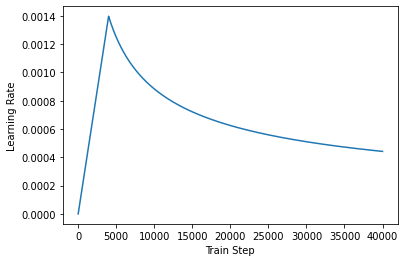

In [ ]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

### Set up the loss and metrics

In [ ]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

### Train the model

In [ ]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [ ]:
transformer.fit(train_batches,
                epochs=20,
                validation_data=val_batches)

Epoch 1/20
810/810 [==============================] - 204s 238ms/step - loss: 6.5841 - masked_accuracy: 0.1456 - val_loss: 4.9946 - val_masked_accuracy: 0.2563
Epoch 2/20
810/810 [==============================] - 192s 237ms/step - loss: 4.5522 - masked_accuracy: 0.3001 - val_loss: 4.0370 - val_masked_accuracy: 0.3619
Epoch 3/20
810/810 [==============================] - 190s 234ms/step - loss: 3.8073 - masked_accuracy: 0.3818 - val_loss: 3.3997 - val_masked_accuracy: 0.4408
Epoch 4/20
810/810 [==============================] - 192s 237ms/step - loss: 3.2709 - masked_accuracy: 0.4412 - val_loss: 2.9859 - val_masked_accuracy: 0.4879
Epoch 5/20
810/810 [==============================] - 191s 236ms/step - loss: 2.8714 - masked_accuracy: 0.4861 - val_loss: 2.7239 - val_masked_accuracy: 0.5233
Epoch 6/20
810/810 [==============================] - 191s 235ms/step - loss: 2.5621 - masked_accuracy: 0.5228 - val_loss: 2.4704 - val_masked_accuracy: 0.5520
Epoch 7/20
810/810 [====================

## Run inference

In [ ]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # As the output language is English, initialize the output with the
    # English `[START]` token.
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

In [ ]:
transformer = Transformer()
translator = Translator(tokenizers, transformer)

In [ ]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

Example 1:

In [ ]:
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é um problema que temos que resolver.
Prediction     : this is a problem that we have to solve .
Ground truth   : this is a problem we have to solve .


Example 2:

In [ ]:
sentence = 'os meus vizinhos ouviram sobre esta ideia.'
ground_truth = 'and my neighboring homes heard about this idea .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : os meus vizinhos ouviram sobre esta ideia.
Prediction     : my neighbors heard about this idea .
Ground truth   : and my neighboring homes heard about this idea .


Example 3:

In [ ]:
sentence = 'vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.'
ground_truth = "so i'll just share with you some stories very quickly of some magical things that have happened."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Prediction     : so i ' m going to quickly share with you some stories of magical things that happened .
Ground truth   : so i'll just share with you some stories very quickly of some magical things that have happened.


## Create attention plots

In [ ]:
sentence = 'este é o primeiro livro que eu fiz.'
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é o primeiro livro que eu fiz.
Prediction     : this is the first book that i did .
Ground truth   : this is the first book i've ever done.


In [ ]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [ ]:
head = 0
# Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]
attention.shape

TensorShape([10, 11])

These are the input (Portuguese) tokens:

In [ ]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(11,), dtype=string, numpy=
array([b'[START]', b'este', b'e', b'o', b'primeiro', b'livro', b'que',
       b'eu', b'fiz', b'.', b'[END]'], dtype=object)>

And these are the output (English translation) tokens:

In [ ]:
translated_tokens

<tf.Tensor: shape=(11,), dtype=string, numpy=
array([b'[START]', b'this', b'is', b'the', b'first', b'book', b'that',
       b'i', b'did', b'.', b'[END]'], dtype=object)>

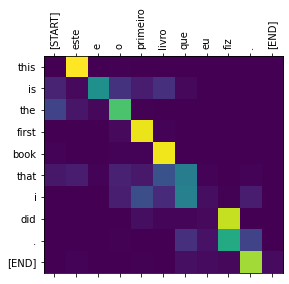

In [ ]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [ ]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

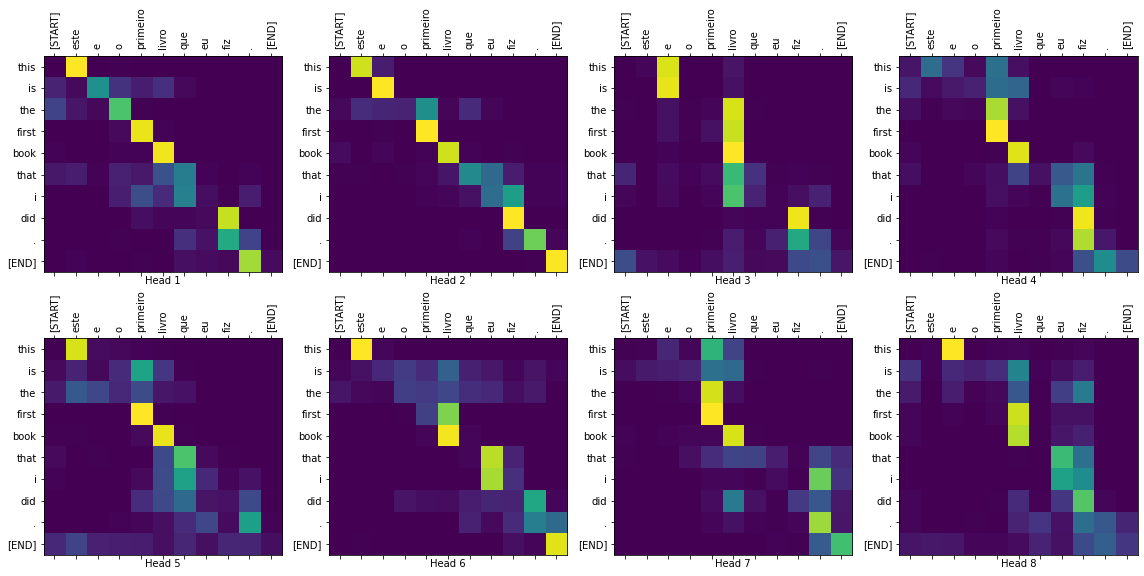

In [ ]:
plot_attention_weights(sentence,
                       translated_tokens,
                       attention_weights[0])

Input:         : Eu li sobre triceratops na enciclopédia.
Prediction     : i read about trivasplass in encyclopedia .
Ground truth   : I read about triceratops in the encyclopedia.


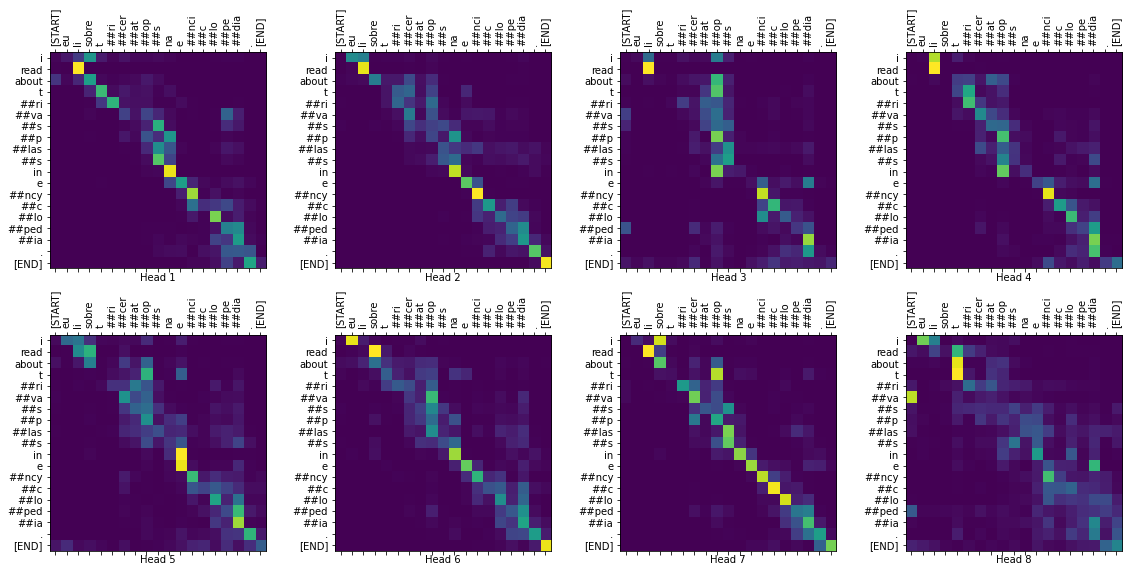

In [ ]:
sentence = 'Eu li sobre triceratops na enciclopédia.'
ground_truth = 'I read about triceratops in the encyclopedia.'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens, attention_weights[0])

## Export the model

In [ ]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result,
     tokens,
     attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

    return result

In [ ]:
export_translator = ExportTranslator(translator)

In [ ]:
export_translator('este é o primeiro livro que eu fiz.').numpy()

b'this is the first book that i did .'

In [ ]:
tf.saved_model.save(export_translator, export_dir='export_translator')

In [ ]:
reloaded = tf.saved_model.load('export_translator')

In [ ]:
reloaded('este é o primeiro livro que eu fiz.').numpy()

b'this is the first book that i did .'

#saving the model to gdrive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import shutil
shutil.copytree('/content/export_translator','/gdrive/MyDrive/export_translator4')

'/gdrive/MyDrive/export_translator4'

In [ ]:
reloaded = tf.saved_model.load('/gdrive/MyDrive/export_translator')

In [ ]:
reloaded('este é o primeiro livro que eu fiz.').numpy()

b'this is the first book i did .'

# computing Bleu score of base model on european portuguese

In [ ]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
TSV_PATH = "/gdrive/MyDrive/port_en.tsv"

In [ ]:
data = pd.read_csv(TSV_PATH, names=["pt_id", "pt_sentence", "en_id", "en_sentence"], sep='\t')
data

,pt_id,pt_sentence,en_id,en_sentence
0,146680,Uma menina chorando abriu a porta.,267881.0,A crying girl opened the door.
1,180624,Vamos tentar alguma coisa!,1276.0,Let's try something.
2,182184,Preciso ir dormir.,1277.0,I have to go to sleep.
3,182184,Preciso ir dormir.,2047094.0,I need to go to sleep.
4,182185,O sinal '&' significa 'e'.,74007.0,The sign '&' stands for 'and'.
...,...,...,...,...
268434,6167545,Qual é o mais velho dos teus irmãos?,11171473.0,Which of your brothers is the eldest?
268435,4753788,Que haja paz!,11171472.0,May there be peace!
268436,11171761,Estamos do lado de fora de sua casa.,11171746.0,We are outside your house.
268437,11171821,Gostou dos nossos móveis?,11171807.0,Do you like our furniture?


In [ ]:
data = data.drop(columns=['pt_id', 'en_id'])
data

,pt_sentence,en_sentence
0,Uma menina chorando abriu a porta.,A crying girl opened the door.
1,Vamos tentar alguma coisa!,Let's try something.
2,Preciso ir dormir.,I have to go to sleep.
3,Preciso ir dormir.,I need to go to sleep.
4,O sinal '&' significa 'e'.,The sign '&' stands for 'and'.
...,...,...
268434,Qual é o mais velho dos teus irmãos?,Which of your brothers is the eldest?
268435,Que haja paz!,May there be peace!
268436,Estamos do lado de fora de sua casa.,We are outside your house.
268437,Gostou dos nossos móveis?,Do you like our furniture?


In [ ]:
NB_BLEU = 1000
RATIO_BLEU = NB_BLEU / len(data['pt_sentence'])
SEED = 69420
tmp_data = data.copy()
bleu_sentences = tmp_data.sample(frac=RATIO_BLEU, random_state=SEED)

(bleu_sentences)

,pt_sentence,en_sentence
112049,Ainda produzem fitas cassete?,Do they still make cassette tapes?
218080,Eu sei que você fez isso de propósito.,I know you did that on purpose.
263193,Mary comprou um presente para a filha da amiga...,Mary bought a present for her friend's daughter.
158124,Você come carne todo dia?,Do you eat meat every day?
17965,A mãe dele estava certa.,His mother was right.
...,...,...
86581,Vou preparar-lhe uma bebida.,I'm going to make you a drink.
208828,Não espero que você acredite.,I don't expect you to believe it.
95774,Tom está estudando francês.,Tom is learning French.
67192,Tom está no hospital agora mesmo.,Tom is in the hospital right now.


In [ ]:
translated = reloaded('este é o primeiro livro que eu fiz.').numpy().decode('UTF-8')
type(translated), translated

(str, 'this is the first book i did .')

In [ ]:
sentences_to_translate = list(bleu_sentences['pt_sentence'])
raw_translation = reloaded(sentences_to_translate[0])
str_translation = raw_translation.numpy().decode('UTF-8')
(raw_translation, str_translation)

(<tf.Tensor: shape=(), dtype=string, numpy=b'still do they produce cas ?'>,
 'still do they produce cas ?')

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
import re

In [ ]:
euro_sentences_to_translate = list(bleu_sentences['pt_sentence'])
euro_objective_translations = list(bleu_sentences['en_sentence'])

In [ ]:
def compute_euro_bleu_score(translator_model):
  score_sum = 0
  for i in range(NB_BLEU):
    candidate = translator_model(euro_sentences_to_translate[i]).numpy().decode('UTF-8').split()
    reference = [re.findall(r"[\w']+|[.,!?;]", euro_objective_translations[i].lower())]
    score_sum += sentence_bleu(reference, candidate)

  score_sum /= NB_BLEU

  return score_sum * 100

In [ ]:
score = compute_euro_bleu_score(export_translator)
f"the bleu score on european portuguese of the original model trained on european portuguese is {score}. Please note that this is a lower bound as we're only comparing to a single sentence"

# loading brazilian portuguese data

In [ ]:
BRAZILIAN_TRAIN_PATH = "/gdrive/MyDrive/brazil_train.csv"
BRAZILIAN_TEST_PATH = "/gdrive/MyDrive/brazil_test.csv"
BRAZILIAN_BLEU_PATH = "/gdrive/MyDrive/brazil_validation.csv"

In [ ]:
def load_csv(filename):
  headers = ["id_qa", "corpus", "question_en_origin", "question_pt_origin", "question_en_paraphase", "question_pt_paraphase", "answer_en_origin", "answer_pt_origin", "answer_en_validate", "answer_pt_validate", "abstract", "eid_article_scopus", "question_generic", "answer_in_text", "answer_difficulty", "question_meaningful", "answer_equivalent", "question_type", "abstract_translated_pt", "pt_question_translated_to_en"]
  useless_headers =["pt_question_translated_to_en", "id_qa", "corpus", "abstract", "eid_article_scopus", "question_generic", "answer_in_text", "answer_difficulty", "question_meaningful", "answer_equivalent", "question_type", "abstract_translated_pt"]
  data = pd.read_csv(filename, names=headers, sep=',')
  data = data.drop(columns=useless_headers)
  data = data.drop(0)
  return data

In [ ]:
bra_train_data = load_csv(BRAZILIAN_TRAIN_PATH)
print(bra_train_data.head(1))
del bra_train_data

                                  question_en_origin  \
1  What method can be used to estimate air–sea se...   

                                  question_pt_origin  \
1  Qual método pode ser usado para estimar os flu...   

                               question_en_paraphase  \
1  To estimate sensitive air-sea sensible and lat...   

                               question_pt_paraphase  \
1  Para estimar fluxos ar-mar de calor sensíveis ...   

                   answer_en_origin                     answer_pt_origin  \
1  The turbulent covariance method.  O método de covariância turbulenta.   

                 answer_en_validate                        answer_pt_validate  
1  The eddy covariance (EC) method.  O método da covariância turbulenta (EC).  


In [ ]:
def load_sentences(filename):
  data = load_csv(filename)

  sentences = dict()

  sentences["en"] = []
  sentences["pt"] = []

  USEFUL_HEADER_PAIRS = [("question_en_origin", "question_pt_origin"),
      ("question_en_paraphase", "question_pt_paraphase"),
      ("answer_en_origin", "answer_pt_origin"),
      ("answer_en_validate", "answer_pt_validate")]

  for index, row in data.iterrows():
      for en_header, pt_header in USEFUL_HEADER_PAIRS:
        if type(row[en_header]) == str and type(row[pt_header]) == str:
          # sentences["en"].append(tf.row[en_header])
          # sentences["pt"].append(row[pt_header])
          #sentences["en"].append(tf.convert_to_tensor(row[en_header],  dtype=tf.string))
          #sentences["pt"].append(tf.convert_to_tensor(row[pt_header],  dtype=tf.string))
          sentences["en"].append(row[en_header])
          sentences["pt"].append(row[pt_header])
  sentences["en"] = np.array(sentences['en'])
  sentences["pt"] = np.array(sentences['pt'])
  return sentences

In [ ]:
bra_train_sentences = load_sentences(BRAZILIAN_TRAIN_PATH)
print(len(bra_train_sentences["en"]))
print(len(bra_train_sentences["pt"]))

6952
6952


In [ ]:
bra_test_sentences = load_sentences(BRAZILIAN_TEST_PATH)
print(len(bra_test_sentences["pt"]))
print(len(bra_test_sentences["en"]))

861
861


In [ ]:
bra_bleu_sentences = load_sentences(BRAZILIAN_BLEU_PATH)
print(len(bra_bleu_sentences["pt"]))
print(len(bra_bleu_sentences["en"]))

855
855


# computing bleu score of base model on brazilian portuguese

In [ ]:
bra_sentences_to_translate = list(bra_bleu_sentences['pt'])
bra_objective_translations = list(bra_bleu_sentences['en'])

In [ ]:
def compute_bra_bleu_score(translator_model):
  score_sum = 0
  for i in range(len(bra_sentences_to_translate)):
    candidate = translator_model(bra_sentences_to_translate[i]).numpy().decode('UTF-8').split()
    reference = [re.findall(r"[\w']+|[.,!?;]", bra_objective_translations[i].lower())]
    score_sum += sentence_bleu(reference, candidate)

  score_sum /= len(bra_sentences_to_translate)

  return score_sum * 100

In [ ]:
score = compute_bra_bleu_score(export_translator)
f"the bleu score on brazilian portuguese of the original model trained on european portuguese is {score}. Please note that this is a lower bound as we're only comparing to a single sentence"

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

"the bleu score on brazilian portuguese of the original model trained on european portuguese is 10.387684244243218. Please note that this is a lower bound as we're only comparing to a single sentence"

# Making the adaptive model

In [ ]:
export_translator.translator.transformer.encoder.trainable = False
export_translator.translator.transformer.decoder.trainable = False
export_translator.translator.transformer.final_layer.trainable = False

In [ ]:
class AdaptiveTransformer(tf.keras.Model):
  def __init__(self, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = export_translator.translator.transformer.encoder
    self.decoder = export_translator.translator.transformer.decoder
    self.adaptive_input = tf.keras.Input(shape=(64, 128, None))
    self.first_adaptive_layer = tf.keras.layers.Dense(target_vocab_size)
    self.second_adaptive_layer = tf.keras.layers.Dense(128)
    self.final_layer = export_translator.translator.transformer.final_layer

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)
    adaptive_1 = self.first_adaptive_layer(x)
    adaptive_2 = self.second_adaptive_layer(adaptive_1)
    # Final linear layer output.
    logits = self.final_layer(adaptive_2)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

In [ ]:
adaptive_transformer = AdaptiveTransformer(
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)
adaptive_transformer

In [ ]:
output = adaptive_transformer((pt, en))

print(en.shape)
print(pt.shape)
print(output.shape)

(64, 91)
(64, 93)
(64, 91, 7010)


In [ ]:
adaptive_transformer.summary()

Model: "adaptive_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  3632768   
                                                                 
 decoder_1 (Decoder)         multiple                  5647104   
                                                                 
 dense_39 (Dense)            multiple                  904290    
                                                                 
 dense_40 (Dense)            multiple                  897408    
                                                                 
 dense_38 (Dense)            multiple                  904290    
                                                                 
Total params: 11,985,860
Trainable params: 1,801,698
Non-trainable params: 10,184,162
_________________________________________________________________


notice how 1,801,698 = 904290 + 897408, so we good

# Preprocessing the brazilian portuguese data for training

In [ ]:
bra_train = tf.data.Dataset.from_tensor_slices((bra_train_sentences["pt"], bra_train_sentences["en"]))
bra_test = tf.data.Dataset.from_tensor_slices((bra_test_sentences["pt"], bra_test_sentences["en"]))
(bra_train, len(bra_train), bra_test, len(bra_test))

(<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>,
 6952,
 <TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>,
 861)

In [ ]:
for pt_examples, en_examples in bra_train.batch(3).take(1):
    print(pt_examples, type(pt_examples))

tf.Tensor(
[b'Qual m\xc3\xa9todo pode ser usado para estimar os fluxos ar-mar de calor sens\xc3\xadvel e latente?'
 b'Para estimar fluxos ar-mar de calor sens\xc3\xadveis e latentes, qual m\xc3\xa9todo \xc3\xa9 utilizado?'
 b'O m\xc3\xa9todo de covari\xc3\xa2ncia turbulenta.'], shape=(3,), dtype=string) <class 'tensorflow.python.framework.ops.EagerTensor'>


# testing the brazilian portuguese dataset

In [ ]:
# Create training and validation set batches.
bra_train_batches = make_batches(bra_train)
bra_val_batches = make_batches(bra_test)

In [ ]:
for (pt, en), en_labels in bra_train_batches.take(1):
  break

print(pt.shape)
print(en.shape)
print(en_labels.shape)

(64, 88)
(64, 74)
(64, 74)


In [ ]:
print(en[0][:10])
print(en_labels[0][:10])

tf.Tensor([   2  120   76   77  756 6407 1240 1413   88   71], shape=(10,), dtype=int64)
tf.Tensor([ 120   76   77  756 6407 1240 1413   88   71 1186], shape=(10,), dtype=int64)


# training the adaptive model

In [ ]:
adaptive_transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [ ]:
adaptive_transformer.fit(bra_train_batches,
                epochs=20,
                validation_data=bra_val_batches)

Epoch 1/20
109/109 [==============================] - 24s 156ms/step - loss: 3.6974 - masked_accuracy: 0.4294 - val_loss: 2.9082 - val_masked_accuracy: 0.5213
Epoch 2/20
109/109 [==============================] - 15s 140ms/step - loss: 3.2331 - masked_accuracy: 0.4679 - val_loss: 2.9102 - val_masked_accuracy: 0.5217
Epoch 3/20
109/109 [==============================] - 15s 139ms/step - loss: 3.2238 - masked_accuracy: 0.4679 - val_loss: 2.8917 - val_masked_accuracy: 0.5207
Epoch 4/20
109/109 [==============================] - 16s 143ms/step - loss: 3.2104 - masked_accuracy: 0.4698 - val_loss: 2.9030 - val_masked_accuracy: 0.5252
Epoch 5/20
109/109 [==============================] - 15s 140ms/step - loss: 3.1863 - masked_accuracy: 0.4721 - val_loss: 2.8531 - val_masked_accuracy: 0.5249
Epoch 6/20
109/109 [==============================] - 15s 139ms/step - loss: 3.1723 - masked_accuracy: 0.4743 - val_loss: 2.8538 - val_masked_accuracy: 0.5297
Epoch 7/20
109/109 [==========================

# build translator wrapper for adaptive transformer

In [ ]:
adaptive_translator = Translator(tokenizers, adaptive_transformer)

In [ ]:
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

translated_text, translated_tokens, attention_weights = adaptive_translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é um problema que temos que resolver.
Prediction     : this is a problem we have to solve .
Ground truth   : this is a problem we have to solve .


In [ ]:
sentence = 'os meus vizinhos ouviram sobre esta ideia.'
ground_truth = 'and my neighboring homes heard about this idea .'

translated_text, translated_tokens, attention_weights = adaptive_translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : os meus vizinhos ouviram sobre esta ideia.
Prediction     : my neighbors heard about this idea .
Ground truth   : and my neighboring homes heard about this idea .


In [ ]:
sentence = 'vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.'
ground_truth = "so i'll just share with you some stories very quickly of some magical things that have happened."

translated_text, translated_tokens, attention_weights = adaptive_translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Prediction     : so i will be very quickly to sharing with some of the magical stories that happened .
Ground truth   : so i'll just share with you some stories very quickly of some magical things that have happened.


In [ ]:
adaptive_export_translator = ExportTranslator(adaptive_translator)

In [ ]:
sentences_to_translate = list(bleu_sentences['pt_sentence'])
raw_translation = adaptive_export_translator(sentences_to_translate[0])
str_translation = raw_translation.numpy().decode('UTF-8')
(raw_translation, str_translation)

(<tf.Tensor: shape=(), dtype=string, numpy=b'they still produce casize ?'>,
 'they still produce casize ?')

In [ ]:
adaptive_export_translator('este é o primeiro livro que eu fiz.').numpy()

b'this is the first book that i was done .'

# bleu score of adaptative model on european portuguese

In [ ]:
score = compute_euro_bleu_score(adaptive_export_translator)
f"the bleu score on european portuguese of the adaptative model trained on european portuguese is {score}. Please note that this is a lower bound as we're only comparing to a single sentence"

"the bleu score on european portuguese of the adaptative model trained on european portuguese is 14.276654811766342. Please note that this is a lower bound as we're only comparing to a single sentence"

# bleu score of adaptative model on brazilian portuguese

In [ ]:
score = compute_bra_bleu_score(adaptive_export_translator)
f"the bleu score on brazilian portuguese of the adaptative model trained on european portuguese is {score}. Please note that this is a lower bound as we're only comparing to a single sentence"

"the bleu score on brazilian portuguese of the adaptative model trained on european portuguese is 13.134624191620537. Please note that this is a lower bound as we're only comparing to a single sentence"

# safe checking that the original model was indeed frozen

In [ ]:
score = compute_euro_bleu_score(export_translator)
f"the bleu score on european portuguese of the original model trained on european portuguese is {score}. Please note that this is a lower bound as we're only comparing to a single sentence"

"the bleu score on european portuguese of the original model trained on european portuguese is 19.0514997602024. Please note that this is a lower bound as we're only comparing to a single sentence"

cool ! it worked properly, time to move to fine tuning

# now working on the fine_tuning

In [ ]:
export_translator.translator.transformer.encoder.trainable = True
export_translator.translator.transformer.decoder.trainable = True
export_translator.translator.transformer.final_layer.trainable = True

In [ ]:
export_translator.translator.transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  3632768   
                                                                 
 decoder_1 (Decoder)         multiple                  5647104   
                                                                 
 dense_38 (Dense)            multiple                  904290    
                                                                 
Total params: 10,184,162
Trainable params: 10,184,162
Non-trainable params: 0
_________________________________________________________________


In [ ]:
export_translator.translator.transformer.fit(bra_train_batches,
                epochs=20,
                validation_data=bra_val_batches)

Epoch 1/20
109/109 [==============================] - 25s 224ms/step - loss: 2.5368 - masked_accuracy: 0.5533 - val_loss: 1.9066 - val_masked_accuracy: 0.6444
Epoch 2/20
109/109 [==============================] - 26s 239ms/step - loss: 1.6213 - masked_accuracy: 0.6745 - val_loss: 1.7221 - val_masked_accuracy: 0.6785
Epoch 3/20
109/109 [==============================] - 26s 239ms/step - loss: 1.2538 - masked_accuracy: 0.7310 - val_loss: 1.6649 - val_masked_accuracy: 0.6924
Epoch 4/20
109/109 [==============================] - 25s 233ms/step - loss: 1.0058 - masked_accuracy: 0.7738 - val_loss: 1.6362 - val_masked_accuracy: 0.7069
Epoch 5/20
109/109 [==============================] - 26s 237ms/step - loss: 0.8304 - masked_accuracy: 0.8042 - val_loss: 1.6408 - val_masked_accuracy: 0.7130
Epoch 6/20
109/109 [==============================] - 25s 233ms/step - loss: 0.7002 - masked_accuracy: 0.8302 - val_loss: 1.6500 - val_masked_accuracy: 0.7146
Epoch 7/20
109/109 [==========================

# bleu score of fine tuned model on european portuguese

In [ ]:
score = compute_euro_bleu_score(export_translator)
f"the bleu score on european portuguese of the fine tuned model trained is {score}. Please note that this is a lower bound as we're only comparing to a single sentence"

"the bleu score on european portuguese of the fine tuned model trained is 4.273410268203451. Please note that this is a lower bound as we're only comparing to a single sentence"

# bleu score of fine tuned model on brazilian portuguese

In [ ]:
score = compute_bra_bleu_score(export_translator)
f"the bleu score on brazilian portuguese of the fine tuned model trained is {score}. Please note that this is a lower bound as we're only comparing to a single sentence"

"the bleu score on brazilian portuguese of the fine tuned model trained is 30.629539239089958. Please note that this is a lower bound as we're only comparing to a single sentence"

# transformer model trained on all data at once

## create the model

In [ ]:
all_data_transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

Quick test

In [ ]:
output = all_data_transformer((pt, en))

print(en.shape)
print(pt.shape)
print(output.shape)

(64, 119)
(64, 119)
(64, 119, 7010)


## merge all the data

In [ ]:
combined_train = train_examples.concatenate(bra_train)
combined_train

<ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [ ]:
combined_val = val_examples.concatenate(bra_test)
combined_val

<ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [ ]:
combined_train_batches = make_batches(combined_train)
combined_train_batches

<PrefetchDataset element_spec=((TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None)), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>

In [ ]:
combined_val_batches = make_batches(combined_val)
combined_val_batches

<PrefetchDataset element_spec=((TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None)), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>

## train on all data at once

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

In [ ]:
all_data_transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [ ]:
all_data_transformer.fit(combined_train_batches,
                epochs=20,
                validation_data=combined_val_batches)

Epoch 1/20
918/918 [==============================] - 225s 235ms/step - loss: 3.9789 - masked_accuracy: 0.2923 - val_loss: 5.0258 - val_masked_accuracy: 0.2146
Epoch 2/20
918/918 [==============================] - 217s 236ms/step - loss: 3.9534 - masked_accuracy: 0.2954 - val_loss: 4.8613 - val_masked_accuracy: 0.2233
Epoch 3/20
918/918 [==============================] - 216s 235ms/step - loss: 3.9891 - masked_accuracy: 0.2921 - val_loss: 5.0265 - val_masked_accuracy: 0.2135
Epoch 4/20
918/918 [==============================] - 219s 238ms/step - loss: 4.0382 - masked_accuracy: 0.2885 - val_loss: 4.7485 - val_masked_accuracy: 0.2320
Epoch 5/20
918/918 [==============================] - 217s 236ms/step - loss: 4.0715 - masked_accuracy: 0.2862 - val_loss: 4.9185 - val_masked_accuracy: 0.2203
Epoch 6/20
918/918 [==============================] - 217s 236ms/step - loss: 4.0266 - masked_accuracy: 0.2900 - val_loss: 4.9734 - val_masked_accuracy: 0.2198
Epoch 7/20
918/918 [====================

# build translator wrapper for the model trained on all data

In [ ]:
all_data_translator = Translator(tokenizers, all_data_transformer)

In [ ]:
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

translated_text, translated_tokens, attention_weights = all_data_translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é um problema que temos que resolver.
Prediction     : it ' s a problem .
Ground truth   : this is a problem we have to solve .


In [ ]:
all_data_export_translator = ExportTranslator(all_data_translator)

In [ ]:
sentences_to_translate = list(bleu_sentences['pt_sentence'])
raw_translation = all_data_export_translator(sentences_to_translate[0])
str_translation = raw_translation.numpy().decode('UTF-8')
(raw_translation, str_translation)

(<tf.Tensor: shape=(), dtype=string, numpy=b'what were the purpose of the piranema ?'>,
 'what were the purpose of the piranema ?')

# evaluate bleu

In [ ]:
score = compute_euro_bleu_score(all_data_export_translator)
f"the bleu score on european portuguese of the trained on both portugueses is {score}. Please note that this is a lower bound as we're only comparing to a single sentence"

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

"the bleu score on european portuguese of the trained on both portugueses is 0.0237692636628387. Please note that this is a lower bound as we're only comparing to a single sentence"

In [ ]:
score = compute_bra_bleu_score(all_data_export_translator)
f"the bleu score on brazilian portuguese of the trained on both portugueses is {score}. Please note that this is a lower bound as we're only comparing to a single sentence"

"the bleu score on brazilian portuguese of the trained on both portugueses is 0.17566069285075073. Please note that this is a lower bound as we're only comparing to a single sentence"

# train on brazilian data only

In [ ]:
brazilian_only_transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

In [ ]:
brazilian_only_transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [ ]:
brazilian_only_transformer.fit(bra_train_batches,
                epochs=20,
                validation_data=bra_val_batches)

Epoch 1/20
109/109 [==============================] - 39s 249ms/step - loss: 8.6636 - masked_accuracy: 0.0339 - val_loss: 8.3856 - val_masked_accuracy: 0.0523
Epoch 2/20
109/109 [==============================] - 24s 224ms/step - loss: 8.0110 - masked_accuracy: 0.0652 - val_loss: 7.5512 - val_masked_accuracy: 0.0913
Epoch 3/20
109/109 [==============================] - 26s 239ms/step - loss: 7.0776 - masked_accuracy: 0.0938 - val_loss: 6.6527 - val_masked_accuracy: 0.0941
Epoch 4/20
109/109 [==============================] - 25s 232ms/step - loss: 6.3746 - masked_accuracy: 0.1177 - val_loss: 6.1644 - val_masked_accuracy: 0.1456
Epoch 5/20
109/109 [==============================] - 25s 227ms/step - loss: 5.9297 - masked_accuracy: 0.1696 - val_loss: 5.6959 - val_masked_accuracy: 0.1957
Epoch 6/20
109/109 [==============================] - 27s 246ms/step - loss: 5.4464 - masked_accuracy: 0.2114 - val_loss: 5.2488 - val_masked_accuracy: 0.2338
Epoch 7/20
109/109 [==========================

# build translator wrapper for the model trained on brazilian data only

In [ ]:
brazilian_only_translater = Translator(tokenizers, brazilian_only_transformer)

In [ ]:
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

translated_text, translated_tokens, attention_weights = brazilian_only_translater(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é um problema que temos que resolver.
Prediction     : this is one indicated that anchored .
Ground truth   : this is a problem we have to solve .


In [ ]:
brazilian_only_export_translator = ExportTranslator(brazilian_only_translater)

In [ ]:
sentences_to_translate = list(bleu_sentences['pt_sentence'])
raw_translation = brazilian_only_export_translator(sentences_to_translate[0])
str_translation = raw_translation.numpy().decode('UTF-8')
(raw_translation, str_translation)

(<tf.Tensor: shape=(), dtype=string, numpy=b'what [UNK] ignewally ?'>,
 'what [UNK] ignewally ?')

# evaluate bleu scores

In [ ]:
score = compute_euro_bleu_score(brazilian_only_export_translator)
f"the bleu score on european portuguese of the trained on brazilian portuguese is {score}. Please note that this is a lower bound as we're only comparing to a single sentence"

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

"the bleu score on european portuguese of the trained on brazilian portuguese is 0.21528671050631212. Please note that this is a lower bound as we're only comparing to a single sentence"

In [ ]:
score = compute_bra_bleu_score(brazilian_only_export_translator)
f"the bleu score on brazilian portuguese of the trained on brazilian portuguese is {score}. Please note that this is a lower bound as we're only comparing to a single sentence"

"the bleu score on brazilian portuguese of the trained on brazilian portuguese is 12.641438000737951. Please note that this is a lower bound as we're only comparing to a single sentence"